In [1]:
# Import the dataset
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
# Show an image
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap = plt.cm.gray_r)
plt.plot()

[]

In [3]:
# Normalize the data
X_train = X_train/255
X_test = X_test/255

In [4]:
# Reshape the data
import numpy as np
n_pixels = np.prod(X_train.shape[1:])

X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [5]:
# Put labels to one hot vectors
from keras.utils import to_categorical

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [6]:
# define the encoder
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.layers.merge import concatenate as concat

n_pixels = 784
n_z = 2
n_classes = 10
m = 250

decoder_dim = 512
encoder_dim = 512

# define the input layer: the pixel values
input_img = Input(shape=(n_pixels,))

# encode
encoder_h = Dense(encoder_dim, activation='relu')(input_img)

# compute the mu and sigma
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# compute z
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with labels
label = Input(shape=(n_classes,))
zc = concat([z, label])

# decode
decoder_hidden = Dense(decoder_dim, activation='relu')
decoder_output = Dense(n_pixels, activation='sigmoid')
decoder = decoder_hidden(zc)
outputs = decoder_output(decoder)

In [7]:
# Define the custom loss
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [8]:
# define the CVAE
cvae = Model([input_img, label], outputs)

# the encoder
encoder = Model([input_img, label], mu)

# the decoder
d_in = Input(shape=(n_z+n_classes,))
d_h = decoder_hidden(d_in)
d_out = decoder_output(d_h)
decoder = Model(d_in, d_out)

In [9]:
# Compile
cvae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])

In [10]:
# fit
from keras.callbacks import EarlyStopping

cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=50,
                     validation_data = ([X_test, y_test], X_test),
                     callbacks = [EarlyStopping(patience = 10)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 121us/step - loss: 198.4936 - KL_loss: 9.3384 - recon_loss: 189.1551 - val_loss: 154.1849 - val_KL_loss: 4.3785 - val_recon_loss: 149.8063
Epoch 2/50
60000/60000 [==============================] - 8s 133us/step - loss: 148.3889 - KL_loss: 4.3497 - recon_loss: 144.0392 - val_loss: 144.5029 - val_KL_loss: 4.3399 - val_recon_loss: 140.1630
Epoch 3/50
60000/60000 [==============================] - 10s 159us/step - loss: 142.8662 - KL_loss: 4.3338 - recon_loss: 138.5324 - val_loss: 141.5043 - val_KL_loss: 4.3588 - val_recon_loss: 137.1455
Epoch 4/50
60000/60000 [==============================] - 11s 178us/step - loss: 140.5069 - KL_loss: 4.3451 - recon_loss: 136.1619 - val_loss: 139.5672 - val_KL_loss: 4.2604 - val_recon_loss: 135.3068
Epoch 5/50
60000/60000 [==============================] - 8s 133us/step - loss: 139.0670 - KL_loss: 4.3735 - recon_loss: 134.6935 - val_loss: 138.51

60000/60000 [==============================] - 8s 130us/step - loss: 130.6931 - KL_loss: 4.7519 - recon_loss: 125.9412 - val_loss: 132.7905 - val_KL_loss: 4.6039 - val_recon_loss: 128.1866
Epoch 42/50
60000/60000 [==============================] - 8s 131us/step - loss: 130.6475 - KL_loss: 4.7547 - recon_loss: 125.8928 - val_loss: 132.7313 - val_KL_loss: 4.7466 - val_recon_loss: 127.9847
Epoch 43/50
60000/60000 [==============================] - 8s 139us/step - loss: 130.5906 - KL_loss: 4.7625 - recon_loss: 125.8280 - val_loss: 132.5466 - val_KL_loss: 4.6603 - val_recon_loss: 127.8862
Epoch 44/50
60000/60000 [==============================] - 8s 131us/step - loss: 130.5178 - KL_loss: 4.7607 - recon_loss: 125.7571 - val_loss: 132.5147 - val_KL_loss: 4.7118 - val_recon_loss: 127.8029
Epoch 45/50
60000/60000 [==============================] - 9s 153us/step - loss: 130.4455 - KL_loss: 4.7621 - recon_loss: 125.6834 - val_loss: 132.7453 - val_KL_loss: 4.7381 - val_recon_loss: 128.0072
Epoch 4

In [11]:
# Print an encoded value just to see
encoded_X0 = encoder.predict([X_train[0].reshape((1, 784)), y_train[0].reshape((1, 10))])
print(encoded_X0)

[[-0.27359134  0.18246214]]


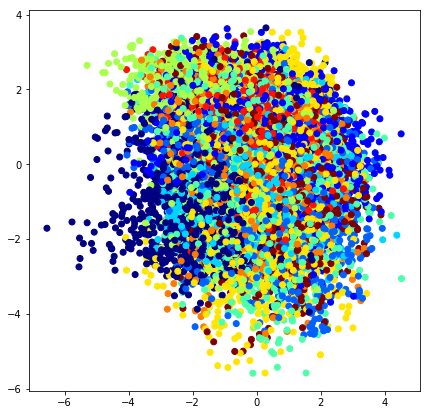

In [12]:
# Compute the encoding mean values and visualize them
mu_train = encoder.predict([X_train, y_train])

plt.figure(figsize=(7, 7))
plt.scatter(mu_train[:, 0], mu_train[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

In [20]:
# Just a simple function to transform a encoded latent space and class value to a one hot vector
def build_vector(digit, z = None):
    out = np.zeros((1, n_z + n_classes))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
vector_3 = build_vector(3)
print(vector_3)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


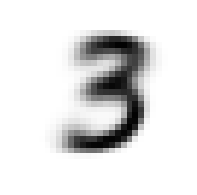

In [24]:
# Show a example of 3 with latent values to zeros
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(vector_3).reshape(28,28), cmap = plt.cm.gray_r)
plt.axis('off')
plt.show()

In [38]:
# Now we can look at the impact of the latent variables on the aspect of the digit
def display_variables(digit, grid_side=8):
    min_z = np.min(mu_train[np.where(Y_train==digit)])
    max_z = np.max(mu_train[np.where(Y_train==digit)])

    count = 1

    plt.figure(figsize=(8, 8))

    for i in range(grid_side):
        for j in range(grid_side):
            # Compute z1 and z2 all over the ranges
            z1 = min_z + i/(grid_side-1)*(max_z-min_z)
            z2 = min_z + j/(grid_side-1)*(max_z-min_z)
            # Compute the input vector
            input_vector = build_vector(digit, [z1, z2])
            # Compute the decoder prediction
            decoded_im = decoder.predict(input_vector)
            # Plot the decoded predicted image
            plt.subplot(grid_side, grid_side, count)
            plt.imshow(decoded_im.reshape(28, 28), cmap = plt.cm.gray_r)

            # Increment the counter for viz
            count +=1
            plt.axis('off')

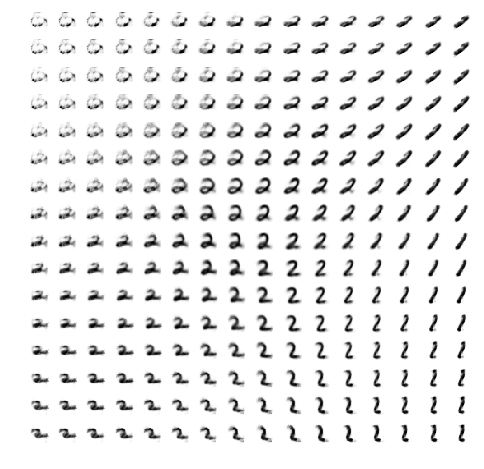

In [36]:
display_variables(2, 16)

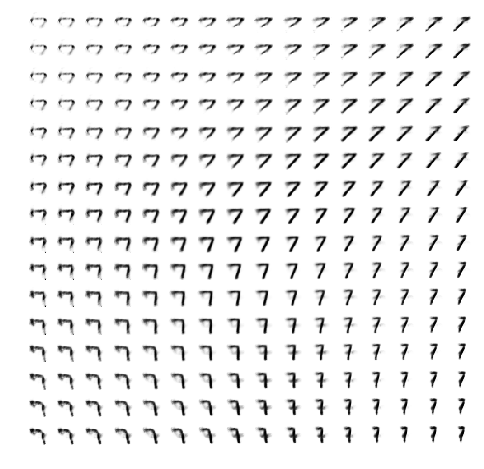

In [37]:
display_variables(7, 16)

As one can see, not all range of latent variables is relevant, but on a given range it changes the style of the digit